In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from utils import load_data, emg_dataset
from model import SERes1d
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
training_dataset = emg_dataset("C:\\Users\\piotr\\Python\\rehabnet\\rehabnet\\data.csv")

training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)

eval_dataset = emg_dataset("C:\\Users\\piotr\\Python\\rehabnet\\rehabnet\\eval.csv")
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=16, shuffle=True)
'''
IDLE        3774
FD           895
FL           890
EX           884
WP           884
FH           883
FS           883
WS           883
WU           883
WR           882
HandOpen       4 -> to jest FD
'''

class_to_index_map = {"IDLE": 0, "FD": 1, "HandOpen": 1, "FH": 2, "FL": 3, "FS": 4, "EX": 5, "WR": 6, "WS": 7, "WP": 8, "WU": 9}

In [4]:
model = SERes1d(8, 10, 16).to(device)
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [5]:
def train(model, dataloader, criteria, optimizer, epochs=10):
    summary(model)
    model.train()
    acc_history = []
    for epoch in range(epochs):
        running_corrects = 0
        predictions = 0
        print(f"Epoch {epoch+1}/{epochs}")
        for i, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            for i in range(len(output)):
                if torch.argmax(output[i]) == target[i]:
                    running_corrects += 1
            loss = criteria(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predictions += len(data)
        accuracy = (running_corrects/predictions)*100
        acc_history.append(accuracy)
        print(f"Loss: {loss.item()}, accuracy: {accuracy}, corrects: {running_corrects}")
    return acc_history

In [6]:
acc_history = train(model, training_dataloader, criteria, optimizer, epochs=50)

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            1,792
├─BatchNorm1d: 1-2                       64
├─ELU: 1-3                               --
├─MaxPool1d: 1-4                         --
├─ResSeBasicBlock: 1-5                   --
|    └─Conv1d: 2-1                       3,072
|    └─BatchNorm1d: 2-2                  64
|    └─ELU: 2-3                          --
|    └─Conv1d: 2-4                       3,072
|    └─BatchNorm1d: 2-5                  64
|    └─SEBlock: 2-6                      --
|    |    └─AdaptiveAvgPool1d: 3-1       --
|    |    └─Sequential: 3-2              128
├─ResSeBasicBlock: 1-6                   --
|    └─Conv1d: 2-7                       3,072
|    └─BatchNorm1d: 2-8                  64
|    └─ELU: 2-9                          --
|    └─Conv1d: 2-10                      3,072
|    └─BatchNorm1d: 2-11                 64
|    └─SEBlock: 2-12                     --
|    |    └─AdaptiveAvgPool1d: 3-3       --
|    |    └

c:\Users\piotr\Python\rehabnet\venv\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\piotr\Python\rehabnet\venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss: 3.4835989475250244, accuracy: 44.4955300127714, corrects: 5226
Epoch 2/50
Loss: 0.3317428231239319, accuracy: 57.454235845040444, corrects: 6748
Epoch 3/50
Loss: 0.2551514208316803, accuracy: 62.758620689655174, corrects: 7371
Epoch 4/50
Loss: 3.8751766681671143, accuracy: 65.44061302681993, corrects: 7686
Epoch 5/50
Loss: 4.103407859802246, accuracy: 67.52660706683696, corrects: 7931
Epoch 6/50
Loss: 4.1394877433776855, accuracy: 69.16134525329927, corrects: 8123
Epoch 7/50
Loss: 4.3163347244262695, accuracy: 70.39591315453384, corrects: 8268
Epoch 8/50
Loss: 4.134613990783691, accuracy: 71.88590889740316, corrects: 8443
Epoch 9/50
Loss: 3.9170780181884766, accuracy: 72.62664963814389, corrects: 8530
Epoch 10/50
Loss: 4.331150054931641, accuracy: 74.51681566624096, corrects: 8752
Epoch 11/50
Loss: 4.529620170593262, accuracy: 75.45338441890166, corrects: 8862
Epoch 12/50
Loss: 4.220767498016357, accuracy: 75.98126862494678, corrects: 8924
Epoch 13/50
Loss: 0.10256738215684891, a

KeyboardInterrupt: 

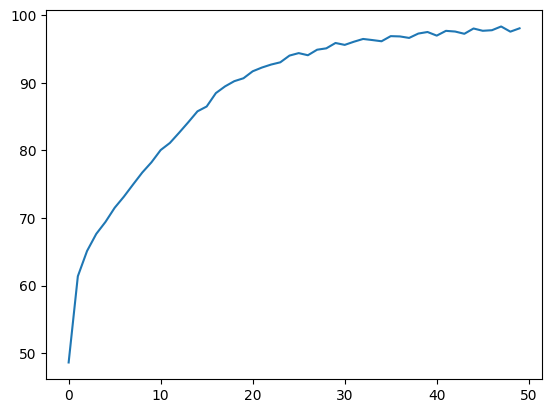

In [16]:
plt.plot(acc_history)

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (6).

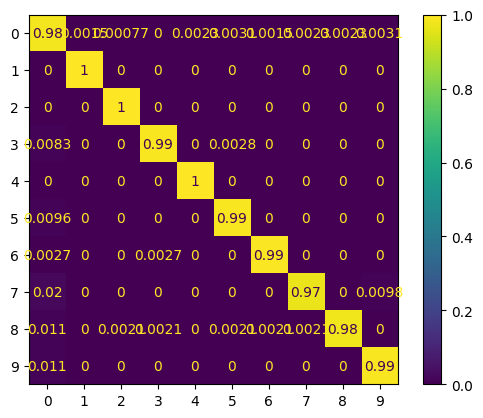

In [17]:
actual = []
predicted = []
for data,label in eval_dataloader:
    data = data.to(device)
    out = model(data)
    actual.extend(label.numpy())
    predicted.extend(torch.sigmoid(out).argmax(dim=1).cpu().numpy())


confusion_matrix = metrics.confusion_matrix(actual, predicted,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5])


cm_display.plot()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()